# KMeans

## Reduction

2023-06-07 00:05:11.670921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-07 00:05:11.671007: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
 82%|████████▏ | 82/100 [05:03<01:06,  3.70s/it]


Centers:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Assignments:
[2 0 5 ... 2 4 7]


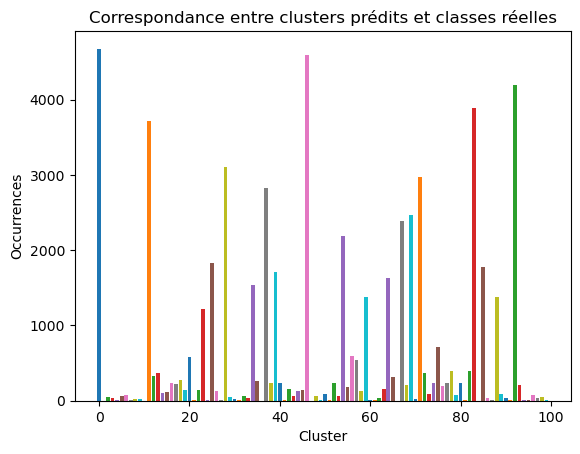

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.colors as mcolors
import pandas as pd

def kmeans(X, k, num_iterations):
    num_samples, num_features = X.shape

    initial_centers = X[np.random.choice(num_samples, k, replace=False)]

    for _ in tqdm(range(num_iterations)):
        distances = np.linalg.norm(X[:, np.newaxis] - initial_centers, axis=-1)

        classes = np.argmin(distances, axis=-1)

        # Mise à jour des centres de cluster
        new_centers = np.array([np.mean(X[classes == i], axis=0) for i in range(k)])

        # Vérification de la convergence
        if np.allclose(initial_centers, new_centers):
            break

        initial_centers = new_centers

    return initial_centers, classes

def kmeans2(X, k, num_iterations):
    initial_centers = tf.random.shuffle(X)[:k]

    # Création des variables pour les centres de cluster
    centers = tf.Variable(initial_centers)

    # Création du graphe TensorFlow
    for _ in tqdm(range(num_iterations)):
        expanded_centers = tf.expand_dims(centers, axis=0)
        expanded_points = tf.expand_dims(X, axis=1)

        distances = tf.reduce_sum(tf.square(expanded_points - expanded_centers), axis=-1)
        assignments = tf.argmin(distances, axis=-1)

        mask = tf.one_hot(assignments, depth=k)
        mask_expanded = tf.expand_dims(mask, axis=-2)

        centers = tf.reduce_sum(tf.expand_dims(X, axis=-1) * mask_expanded, axis=1) / tf.reduce_sum(mask_expanded, axis=1)

    return centers, assignments



(x_train,y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train2 = np.array([x.flatten() for x in x_train])
#X = tf.constant(x_train2)


k = 10

# Exécution de l'algorithme des k-means
centers, assignments = kmeans(x_train2, k, num_iterations=100)

# Récupération des résultats
print("Centers:")
print(centers)

print("Assignments:")
print(assignments)



# Exemple de données de clusters prédits et de classes réelles
clusters_predits = assignments
classes_reelles = y_train

# Compter les occurrences de chaque paire (cluster, classe)
occurrences = {}
for cluster, classe in zip(clusters_predits, classes_reelles):
    key = (cluster, classe)
    occurrences[key] = occurrences.get(key, 0) + 1

# Préparer les données pour le bar plot
categories = list(set(clusters_predits))
valeurs = [occurrences.get((cluster, classe), 0) for cluster in categories for classe in np.arange(k)]

# Générer une liste de couleurs pour chaque classe
couleurs_classes = list(mcolors.TABLEAU_COLORS.values())[:k]  # Génère k couleurs

# Tracer le bar plot avec les couleurs des classes
plt.bar(range(len(valeurs)), valeurs, color=couleurs_classes)

# Étiquettes des axes et titre
plt.xlabel('Cluster')
plt.ylabel('Occurrences')
plt.title('Correspondance entre clusters prédits et classes réelles')


# Afficher le bar plot
plt.show()

## Compression - Decompression

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml


mnist = fetch_openml("mnist_784", version=1)


In [9]:
import numpy as np

X_train = mnist['data'].to_numpy()


def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))


In [12]:
from random import uniform
from tqdm.notebook import tqdm

class KMeans:
    def __init__(self, k: int = 5, max_iter: int = 200):
        self.k = k
        self.max_iter = max_iter

    def run(self, X):
        prev_cent = None
        min_, max_ = np.min(X, axis=0), np.max(X, axis=0)
        self.centroids = [uniform(min_, max_) for _ in range(self.k)]

        for it in tqdm(range(self.max_iter)):
            if not np.not_equal(self.centroids, prev_cent).any():
                break
            sorted_points = [[] for _ in range(self.k)]
            for x in X:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                # print(centroid_idx, dists, x)
                sorted_points[centroid_idx].append(x)
            prev_cent = self.centroids
            self.centroids = [np.mean(cluster, axis=0)
                              for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = prev_cent[i]
        return self.centroids

    def eval(self, X, cent = None):
        if cent:
            self.centroids = cent
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return np.array(centroids), centroid_idxs


In [5]:
kmeans = KMeans(k=5, max_iter=300)

kmeans.run(X_train)

centers, classif = kmeans.eval(X_train)


  0%|          | 0/300 [00:00<?, ?it/s]

In [24]:
from skimage import io
import numpy as np
from tqdm.notebook import tqdm

class Compressor:
    def __init__(self, size = 64):
        self.size = size
        self.kmeans = None
        self.centers = None
        self.data = None

    def Compress(self, imgarr = None, imgpath: str = None, outpath: str = None, data_train = None, train = False):
        image = io.imread(imgpath) if imgpath else imgarr
        with np.printoptions(threshold=np.inf):
            print(image.shape)
            # print(image)

        self.data = data_train if data_train is not None else self.data

        rows = image.shape[0]
        cols = image.shape[1]

        if data_train is None:
            image = image.flatten()
        elif train:
            image = image.reshape(rows, cols * image.shape[2])
        else:
            image = image.reshape(rows*cols, 3)

        print("kmeans start")
        if not self.kmeans or train:
            self.kmeans = KMeans(k=self.size, max_iter=300)
            self.centers = self.kmeans.run(image if self.data is None else self.data)
        
        if train:
            return None, self.centers
        
        print("kmeans eval")

        _, labels_ = self.kmeans.eval(image)

        print(labels_)
        labels_ = np.array(labels_).reshape(rows, cols)

        if outpath:
            io.imsave(outpath, labels_)

        return labels_, self.centers

    def Decompress(self, imgarr = None, imgpath: str = None, outpath: str = None, cent = None):
        #Read the image
        if cent:
            self.centers = cent
        image = io.imread(imgpath) if imgpath else imgarr
        with np.printoptions(threshold=np.inf):
            print(image.shape)
            # print(image)
        # io.imshow(image)
        # io.show()

        #Dimension of the original image
        rows = image.shape[0]
        cols = image.shape[1]

        new = np.zeros((rows, cols, 3), dtype=np.uint8)
        self.centers = np.array(self.centers)
        print(self.centers.shape)
        for i in tqdm(range(rows)):
            for j in range(cols):
                index = image[i, j]
                new[i, j, :] = self.centers[index, :]
        io.imshow(new)
        io.show()

        if outpath:
            io.imsave(outpath, new)

        return new


In [9]:
comp = Compressor(14)

# X_train[12]

lbl, cent = comp.Compress(imgpath="./kmeans/compress/data/images.jpeg", outpath = './kmeans/compress/data/images_14.jpeg')

(225, 225, 3)
kmeans start


  0%|          | 0/300 [00:00<?, ?it/s]

kmeans eval


/tmp/ipykernel_32258/3661756062.py:39: UserWarning: ./kmeans/compress/data/images_14.jpeg is a low contrast image
  io.imsave(outpath, labels_)
Lossy conversion from int64 to uint8. Range [0, 13]. Convert image to uint8 prior to saving to suppress this warning.


[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 6, 12, 12, 12, 12, 6, 10, 0, 4, 4, 4, 0, 11, 3, 3, 6, 6, 8, 12, 12, 12, 12, 12, 12, 12, 2, 2, 2, 2, 2, 12, 12, 12, 12, 12, 12, 12, 12, 12, 8, 8, 8, 6, 6, 6, 6, 6, 8, 8, 8, 12, 12, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 11, 11, 11, 11, 1, 6, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 2, 2, 2, 2, 2, 2, 2, 12, 10, 10, 10, 9, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 13, 13, 13, 11, 13, 4, 4, 13, 3, 13, 13, 13, 13, 11, 11, 11, 11, 1, 1, 9, 9, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 12, 8, 8, 8, 6, 11, 10, 11, 11, 3, 11, 10, 11, 1, 1, 9, 9, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 5, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 3, 6, 12, 12, 12, 12, 6, 11, 11, 4, 4, 10, 11, 3, 6, 6, 

dans le dataset de mnist il y a 2 couleur donc la compression avec 2 centroids est suffisante a priori, nous pouvons tester cette hypothese:

In [13]:
import tensorflow as tf
tf.keras.datasets.mnist.load_data(path="mnist.npz")

(x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.mnist.load_data()

In [25]:
mnist_comp = Compressor(2)

X_10 = x_tr[:10]
res_10 = []

lbl, cents = mnist_comp.Compress(imgarr=x_tr, data_train=x_tr, train=True)



for i in tqdm(range(10)):
    lbl, cents = mnist_comp.Compress(imgarr=X_10[i])
    res_10.append(mnist_comp.Decompress(imgarr=lbl))

fig, axes = plt.subplots(2, 5, figsize=(15, 25))
axes = axes.flatten()

for i in range(len(res_10)):
    axes[i].imshow(res_10[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
    


(60000, 28, 28)
kmeans start


  0%|          | 0/300 [00:00<?, ?it/s]

28 [[189.40337466 357.51230582 485.64921133 511.70488632 518.02179676
  554.27571502 571.20490498 571.33697401 564.29578294 566.91485655
  566.02967454 571.39751855 590.4453076  584.20542029 574.35731691
  567.52547729 568.34072853 592.22322317 562.24512482 539.63613632
  554.0946044  579.22009085 565.23665469 533.08118122 542.71648514
  522.38176416 486.27712319 315.99437396]
 [102.73448501 193.91862837 263.42150297 277.55438923 289.19453878
  364.78398358 387.44059029 409.91327799 462.28948293 481.01827338
  496.92951257 552.42071174 610.45967703 610.09564961 557.09357117
  554.56495267 576.46351809 618.25229269 510.07753615 414.83603065
  362.49920474 397.15174218 372.17064637 295.59399979 294.37542338
  283.34564585 263.76208931 171.39884298]] [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   

IndexError: list index out of range

[[ 1  1  1 ...  4  4  5]
 [ 1  1  1 ...  4  4  5]
 [ 1  1  1 ...  4  4  5]
 ...
 [ 7  7 11 ...  9  5  9]
 [ 7  3 11 ...  9  9  9]
 [ 7  7  7 ...  9  9  9]]
(225, 225)
(12, 3)


  0%|          | 0/225 [00:00<?, ?it/s]

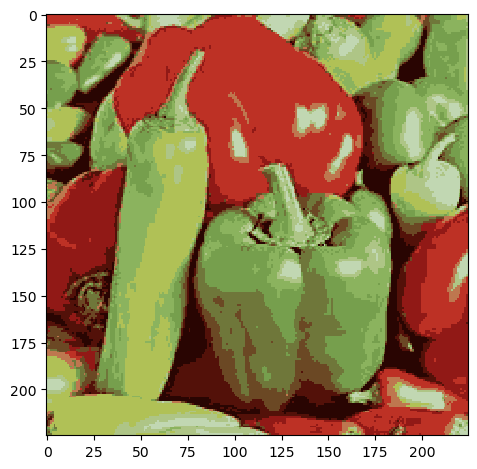

array([[[189,  49,  37],
        [189,  49,  37],
        [189,  49,  37],
        ...,
        [176, 193,  86],
        [176, 193,  86],
        [174, 197, 134]],

       [[189,  49,  37],
        [189,  49,  37],
        [189,  49,  37],
        ...,
        [176, 193,  86],
        [176, 193,  86],
        [174, 197, 134]],

       [[189,  49,  37],
        [189,  49,  37],
        [189,  49,  37],
        ...,
        [176, 193,  86],
        [176, 193,  86],
        [174, 197, 134]],

       ...,

       [[111, 119,  58],
        [111, 119,  58],
        [139, 179,  94],
        ...,
        [193, 215, 178],
        [174, 197, 134],
        [193, 215, 178]],

       [[111, 119,  58],
        [107,  72,  36],
        [139, 179,  94],
        ...,
        [193, 215, 178],
        [193, 215, 178],
        [193, 215, 178]],

       [[111, 119,  58],
        [111, 119,  58],
        [111, 119,  58],
        ...,
        [193, 215, 178],
        [193, 215, 178],
        [193, 215, 178]]

In [ ]:
comp = Compressor(14)

print(lbl)

comp.Decompress(imgarr=lbl, outpath = './kmeans/compress/data/images_14_dec.jpeg', cent=cent)

## Generate

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.utils import parallel_backend
from tqdm import tqdm
import tensorflow as tf

2023-06-07 01:10:47.678633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-07 01:10:47.678694: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [28]:
# Function to implement steps given in previous section
def kmeansgenerate(k, no_of_iterations):
    # Flatten the images into vectors
    x_train_flatten = x_train.reshape(x_train.shape[0], -1)
    x_test_flatten = x_test.reshape(x_test.shape[0], -1)

    # Combine the training and testing data
    x_combined = np.concatenate((x_train_flatten, x_test_flatten), axis=0)

    # Step 1: Randomly choosing initial centroids
    idx = np.random.choice(len(x_combined), k, replace=False)

    centroids = x_combined[idx, :]
    size_test = x_combined[:, np.newaxis] - centroids
    # Step 2: Finding the distance between centroids and all the data points
    with parallel_backend('threading'):  # Parallelize computation
        distances = np.linalg.norm(x_combined[:, np.newaxis] - centroids, axis=2)

    # Step 3: Assigning data points to the closest centroid
    points = np.argmin(distances, axis=1)

    # Repeating the above steps for a defined number of iterations with tqdm
    for _ in tqdm(range(no_of_iterations), desc='K-means Iterations'):
        # Step 4: Updating the centroids
        centroids = []
        for idx in range(k):
            # Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x_combined[points == idx].mean(axis=0)
            centroids.append(temp_cent)
        centroids = np.vstack(centroids)  # Updated Centroids

        # Updating the distances and reassigning the points
        with parallel_backend('threading'):  # Parallelize computation
            distances = np.linalg.norm(x_combined[:, np.newaxis] - centroids, axis=2)
        points = np.argmin(distances, axis=1)

    # Returning the assigned points
    return centroids 

In [22]:
k = 10  # Number of clusters
no_of_iterations = 100  # Number of iterations for K-means
# centroids = kmeansgenerate(k, no_of_iterations) # Apply K-means clustering
km = KMeans(k, no_of_iterations)
print(x_train.shape)
x_flat = x_train.reshape(x_train.shape[0], -1)
print(x_flat.shape)
centroids = np.array(km.run(x_flat))



(60000, 28, 28)
(60000, 784)


  0%|          | 0/100 [00:00<?, ?it/s]

/home/osmonoz/anaconda3/envs/tf-gpu-cuda8/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/osmonoz/anaconda3/envs/tf-gpu-cuda8/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


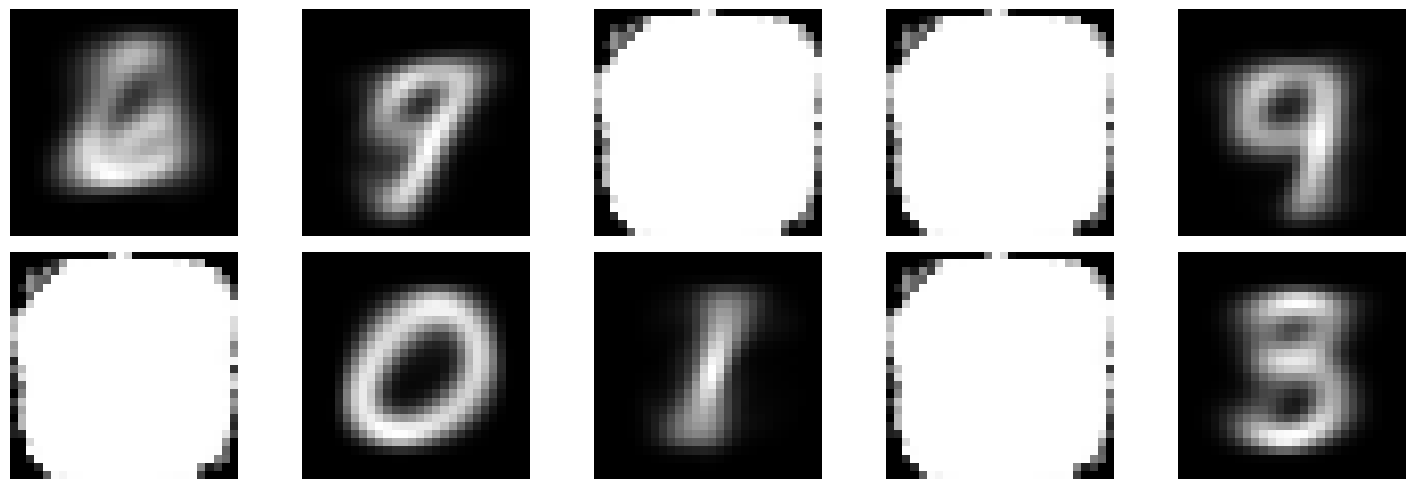

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
axes = axes.flatten()

as_image = centroids.reshape(centroids.shape[0], 28, 28)

for i in range(len(as_image)):
    axes[i].imshow(as_image[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
    

# PCA

## Reduction

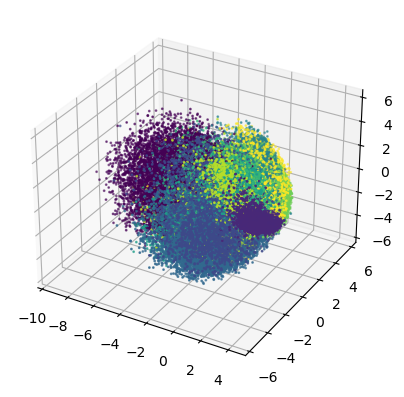

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

n_components = 3
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Combine the training and testing data
X = np.concatenate((x_train, x_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

# Flatten the images into vectors
X = X.reshape(X.shape[0], -1)

# Convert data to float and scale it between 0 and 1
X = X.astype(float) / 255.0

# Calculate the mean vector
mean_vector = np.mean(X, axis=0)

# Subtract the mean vector from the data
X_centered = X - mean_vector

# calculating the covariance matrix of the mean-centered data.
cov_mat = np.cov(X_centered, rowvar=False)

# Calculating Eigenvalues and Eigenvectors of the covariance matrix
eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

# sort the eigenvalues in descending order
sorted_index = np.argsort(eigen_values)[::-1]

sorted_eigenvalue = eigen_values[sorted_index]
# similarly sort the eigenvectors
sorted_eigenvectors = eigen_vectors[:, sorted_index]

# select the first n eigenvectors, n is desired dimension
# of our final reduced data.
eigenvector_subset = sorted_eigenvectors[:, 0:n_components]

X_reduced = np.dot(X_centered, eigenvector_subset)

x = X_reduced[:,0]
y = X_reduced[:,1]
z = X_reduced[:,2]



# Couleurs correspondant à chaque catégorie
unique_values = np.unique(y)
count = len(unique_values)
colors = list(mcolors.TABLEAU_COLORS.values())[:count]

# Création du scatter plot en 3D avec des couleurs différentes pour chaque catégorie
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=Y, cmap=plt.cm.get_cmap('viridis', len(colors)), s=1)

# Affichage du plot
plt.show(block=True)

## Compression - Decompression

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

In [27]:
def pca_compress_decompress(n_components=30):
    # Load the MNIST dataset
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

    # Combine the training and testing data
    X = np.concatenate((x_train, x_test), axis=0)

    # Flatten the images into vectors
    X = X.reshape(X.shape[0], -1)

    # Convert data to float and scale it between 0 and 1
    X = X.astype(float) / 255.0

    # Calculate the mean vector
    mean_vector = np.mean(X, axis=0)

    # Subtract the mean vector from the data
    X_centered = X - mean_vector

    # calculating the covariance matrix of the mean-centered data.
    cov_mat = np.cov(X_centered , rowvar = False)

    #Calculating Eigenvalues and Eigenvectors of the covariance matrix
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    #sort the eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    
    sorted_eigenvalue = eigen_values[sorted_index]
    #similarly sort the eigenvectors 
    sorted_eigenvectors = eigen_vectors[:,sorted_index]


    # select the first n eigenvectors, n is desired dimension
    # of our final reduced data.
    eigenvector_subset = sorted_eigenvectors[:,0:n_components]

    #Transform the data 
    X_reduced = np.dot(eigenvector_subset.transpose(),X_centered.transpose()).transpose()

    # Reconstruct the data from the projected space
    X_reconstructed = np.dot(X_reduced, eigenvector_subset.T) + mean_vector

    return X_reconstructed

In [28]:
n_components = 750
X_reconstructed = pca_compress_decompress(n_components=n_components)
print(X_reconstructed.shape)

(70000, 784)


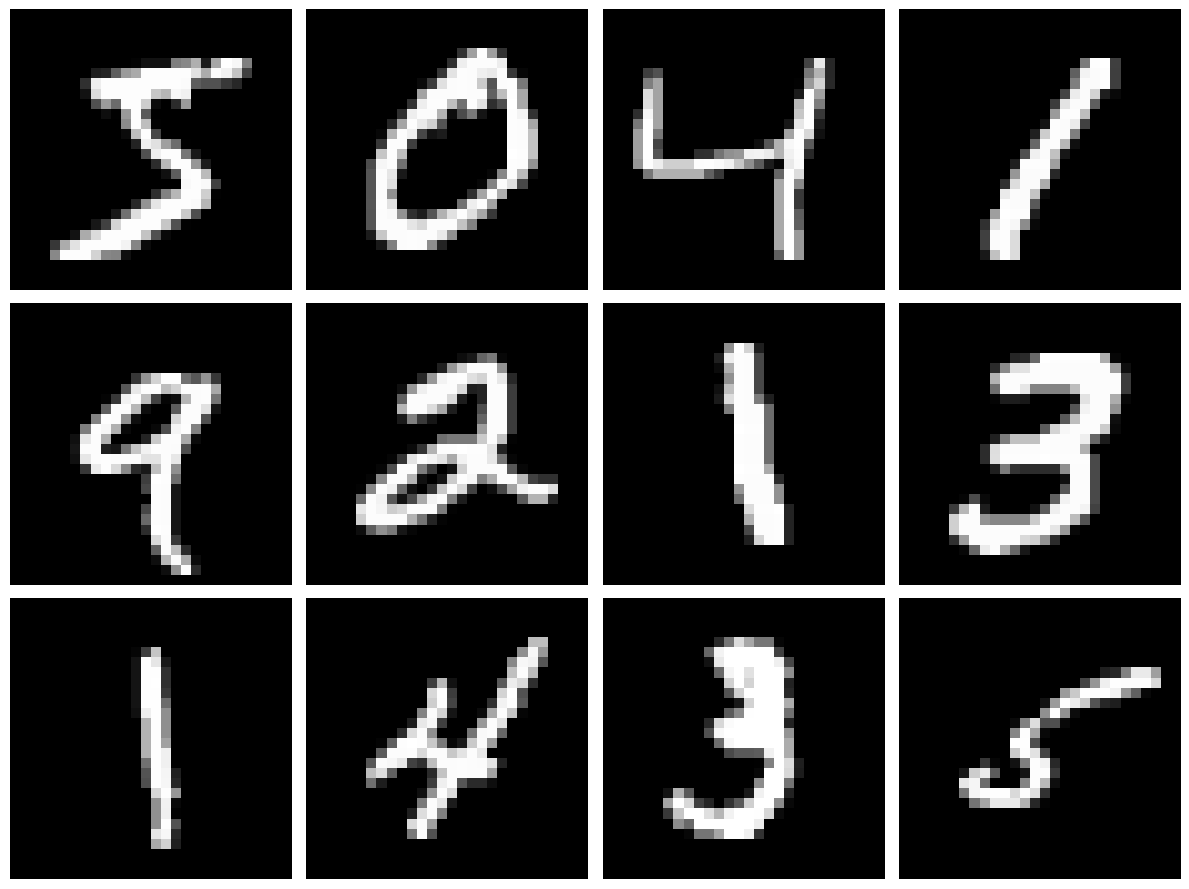

In [29]:

# Reshape the reconstructed data into images
X_reconstructed = X_reconstructed.reshape((-1, 28, 28))

# Display the generated images in a grid
num_images = 12
num_rows = num_images // 4

fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3*num_rows))
axes = axes.flatten()

for i in range(num_images):
    axes[i].imshow(X_reconstructed[i], cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Generate

In [30]:
import tensorflow as tf
tf.keras.datasets.mnist.load_data(path="mnist.npz")

(x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.mnist.load_data()

In [31]:
def display_mnist(xs, row: int = None, col: int = None, width: int = None):
    if row:
        if not width:
            width = 3 * (row + 1) if row else 12
        fig, axes = plt.subplots(row + 1, col, figsize=(12, width))
    else:
        fig, axes = plt.subplots((xs.shape[0] // 4) + 1, 4, figsize=(12, 3*((xs.shape[0] // 4))))
    axes = axes.flatten()

    for i in range(len(xs)):
        axes[i].imshow(xs[i], cmap='gray')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [32]:
import copy

def passbyval(func):
  def new(*args):
      cargs = [copy.deepcopy(arg) for arg in args]
      return func(*cargs)
  return new

@passbyval
def loop(minmax, steps, deep, arr, i, fullarr):
  index = i
  it = minmax[deep][0]
  step = steps[deep]
  while it < minmax[deep][1]:
    try:
      arr[i] = copy.deepcopy(it)
    except:
      arr.append(it)
    if deep < len(steps) - 1:
      fullarr = copy.deepcopy(loop(minmax, steps, deep + 1, arr, index + 1, fullarr))
    else:
      fullarr.append(copy.deepcopy(arr))
    it += step
  return(fullarr)

class PCA:
  def __init__(self, n_values: int = 3):
    self._n_values_ = n_values

  def process(self, data):
    # Flatten the images into vectors
    data = data.reshape(data.shape[0], -1)
    # Convert data to float and scale it between 0 and 1
    data = data.astype(float) / 255.0
    # Calculate the mean vector
    self._mean_vector_ = np.mean(data, axis=0)
    # Subtract the mean vector from the data
    X_centered = data - self._mean_vector_
    return (X_centered)

  def fit(self, X):
    self._cov_mat_ = np.cov(X, rowvar=False)
    eigen_values , eigen_vectors = np.linalg.eigh(self._cov_mat_)

    #sort the eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    
    self._sorted_eigenvalue_ = eigen_values[sorted_index]
    #similarly sort the eigenvectors 
    self._sorted_eigenvectors_ = eigen_vectors[:,sorted_index]

    self._eigenvectors_sub_ = self._sorted_eigenvectors_[:,0:self._n_values_]
    self.X_reduced = np.dot(self._eigenvectors_sub_.transpose(),X.transpose()).transpose()

    return self.X_reduced
  
  @property
  def eigs(self):
    return self._eigenvectors_sub_
  
  def generate(self, x_base = None, rand: bool = False, n: int = 12):
    # (rows, cols) = self.X_reduced.shape
    # print (rows, cols)
    if rand:
      min_x = self.X_reduced.flatten().min()
      max_x = self.X_reduced.flatten().max()
      x_to_gen = []
      for i in range(10):
        x_to_gen.append(np.random.uniform(low=min_x, high=max_x, size=(self._n_values_,)))
      x_to_gen = np.array(x_to_gen)
    x_gen = np.dot(x_to_gen if rand else x_base, self._eigenvectors_sub_.T) + self._mean_vector_
    return (x_gen)
  
  def display_table(self, max_image: int = 500):
    x_t_img = self.X_reduced.T

    min_max = [(xti.min(), xti.max()) for xti in x_t_img]

    stepn = int(max_image**(1/self._n_values_))

    steps = [(mx - mn) / stepn for (mn, mx) in min_max]
    arr1 = []
    arr2 = []

    print(min_max, steps, stepn)

    x_base_gen = loop(min_max, steps, 0, arr1, 0, arr2)
    print(x_base_gen)
    x_base_gen = np.array(x_base_gen)
    x_generate = self.generate(x_base_gen)
    print(x_generate.shape)
    x_generate = x_generate.reshape(x_generate.shape[0], 28, 28)
    print(x_generate)
    display_mnist(x_generate, stepn, stepn)


In [33]:
pca = PCA(6)
x_img = np.concatenate((x_tr, x_te), axis=0)
print(x_img.shape)
x_img_process = pca.process(x_img)
x_red = pca.fit(x_img_process)

x_red.shape

(70000, 28, 28)


(70000, 6)

10


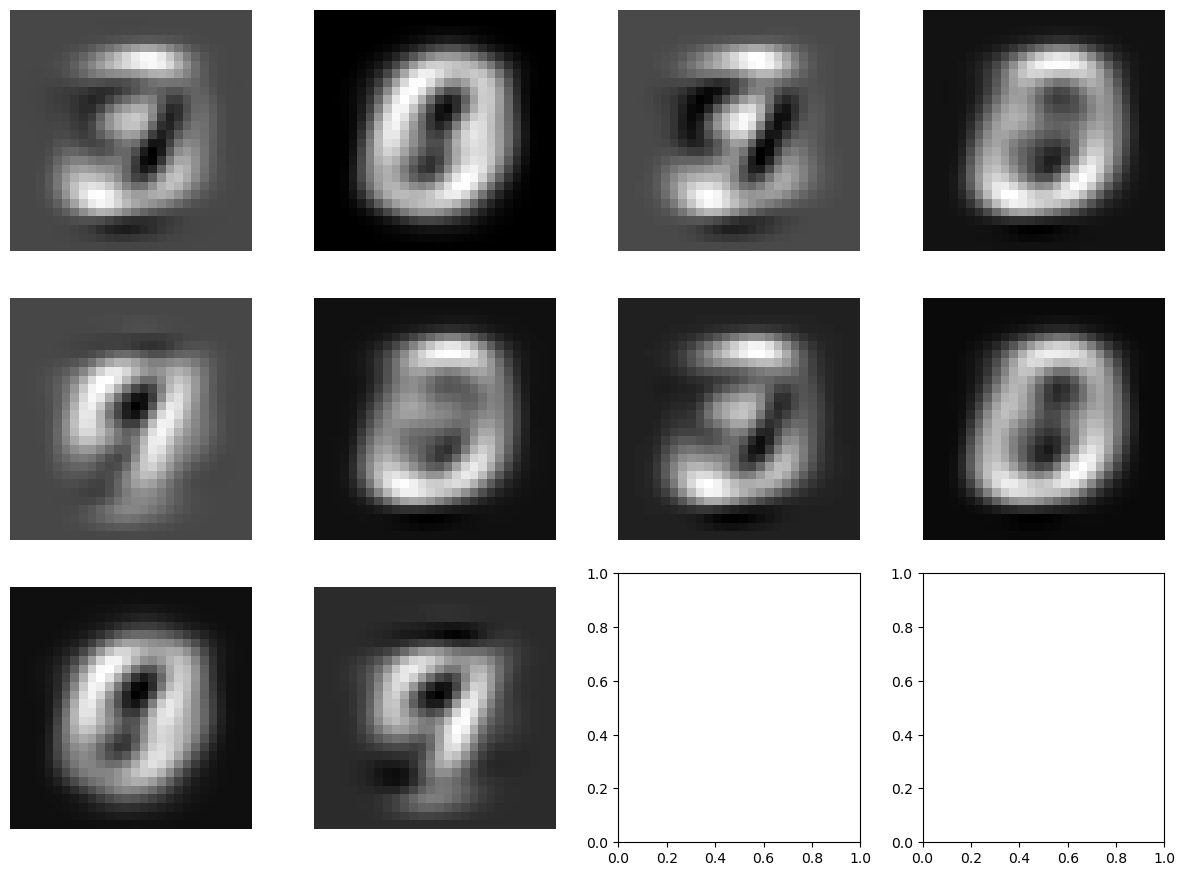

In [ ]:
x_gen = pca.generate(rand=True)
print(x_gen.shape[0])
x_gen = x_gen.reshape(x_gen.shape[0], 28, 28)
display_mnist(x_gen)

(110, 28, 28)


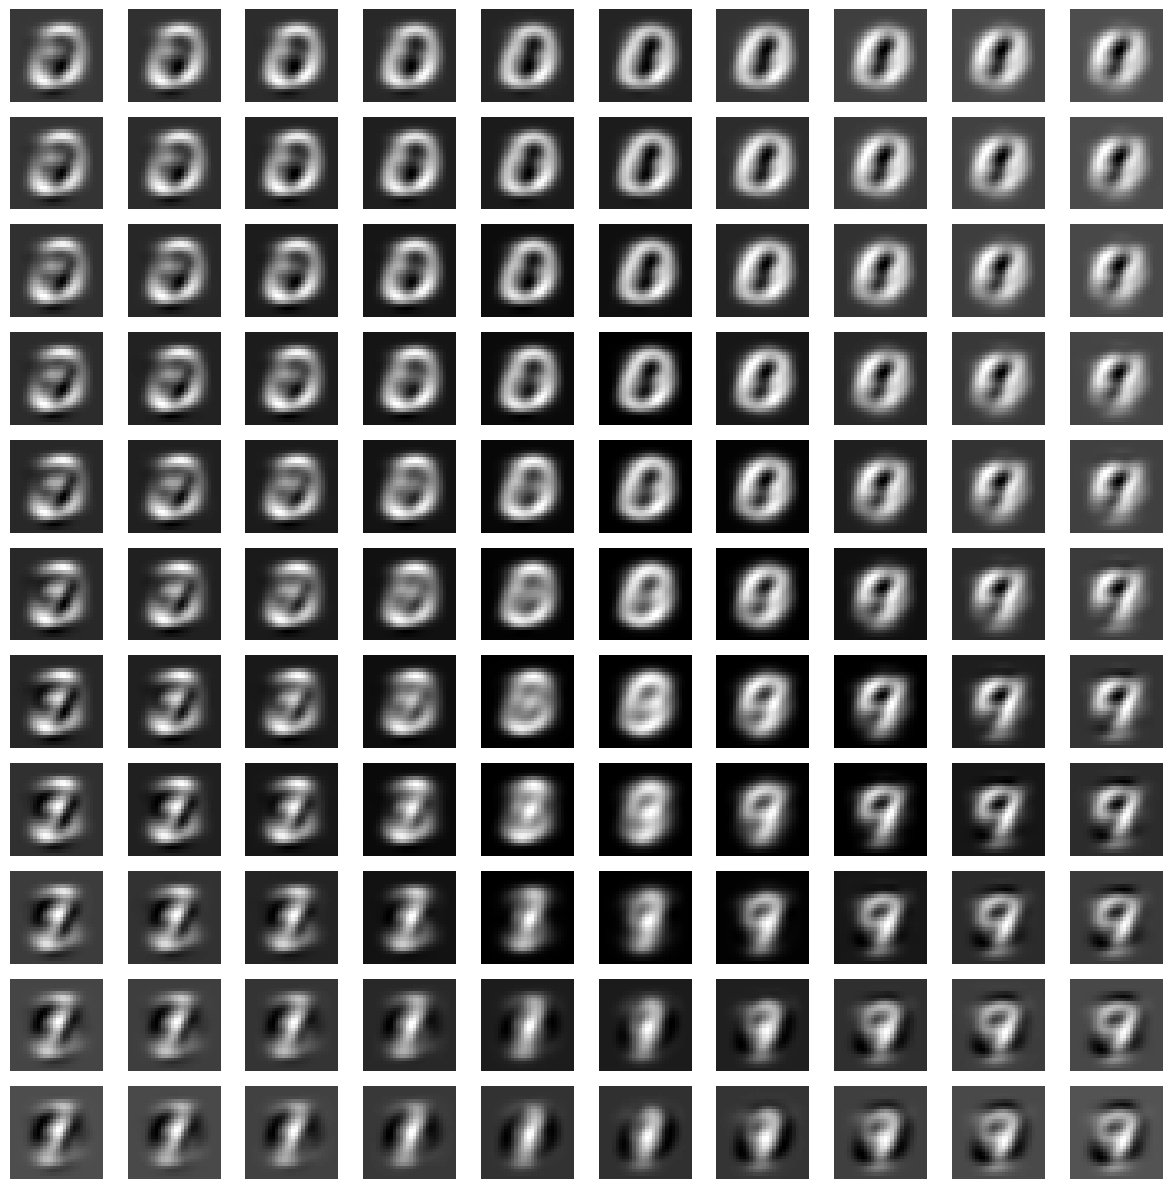

In [ ]:
x_t_img = x_red.T

min_red_x = x_t_img[0].min()
max_red_x = x_t_img[0].max()
min_red_y = x_t_img[1].min()
max_red_y = x_t_img[1].max()

step_x = (max_red_x - min_red_x) / 10
step_y = (max_red_y - min_red_y) / 10

x = min_red_x

x_base_gen = []

while x < max_red_x:
  y = min_red_y
  while y < max_red_y:
    x_base_gen.append(np.array([x, y]))
    y += step_y
  x += step_x

x_base_gen = np.array(x_base_gen)


x_gen_table = pca.generate(x_base_gen)
x_gen_table = x_gen_table.reshape(x_gen_table.shape[0], 28, 28)


print(x_gen_table.shape)


display_mnist(x_gen_table, 10, 10)


[(-9.348955204851649, 4.2397839314757375), (-5.603368650082599, 5.74293159454889), (-5.599050469100766, 5.788564396665481), (-5.981002187296996, 6.213920731310243), (-5.445527901626364, 5.089137509493298), (-5.001733543122861, 4.876769613823786)] [4.529579712109129, 3.7821000815438297, 3.7958716219220823, 4.064974306202413, 3.511555137039887, 3.292834385648882] 3
[[-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -5.445527901626364, -5.001733543122861], [-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -5.445527901626364, -1.708899157473979], [-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -5.445527901626364, 1.5839352281749033], [-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -1.933972764586477, -5.001733543122861], [-9.348955204851649, -5.603368650082599, -5.599050469100766, -5.981002187296996, -1.933972764586477, -1.708899157473979], [-9.348955204851649, -5

IndexError: index 12 is out of bounds for axis 0 with size 12

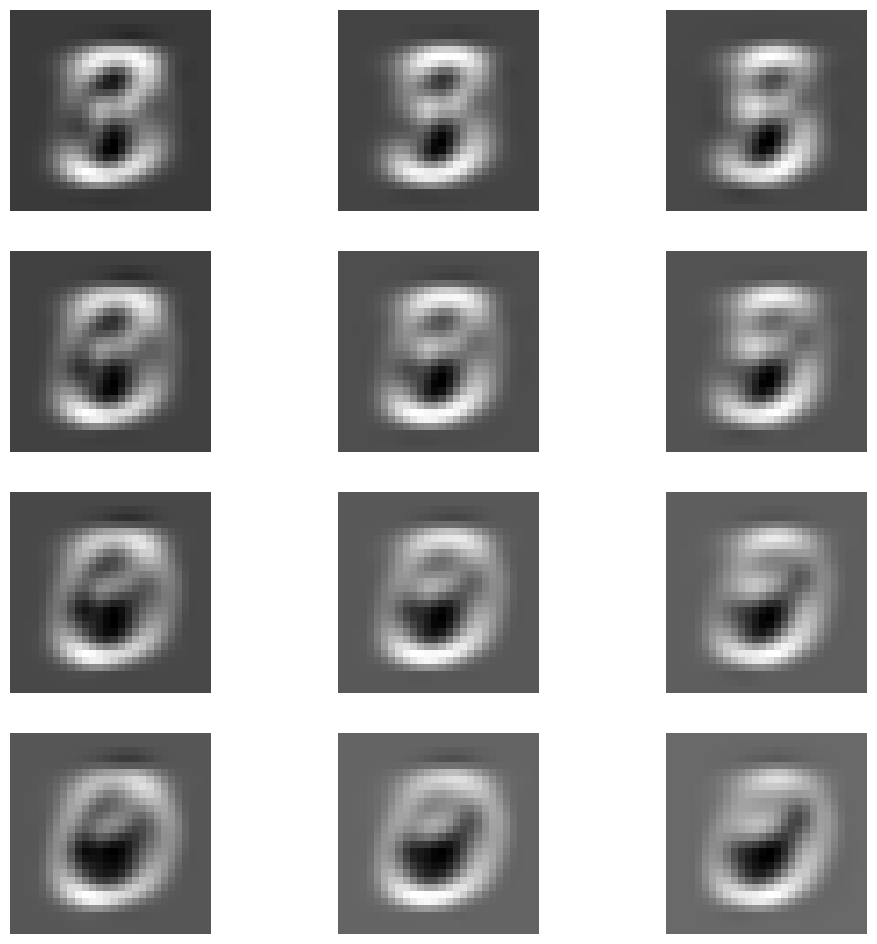

In [ ]:
pca.display_table(4096)

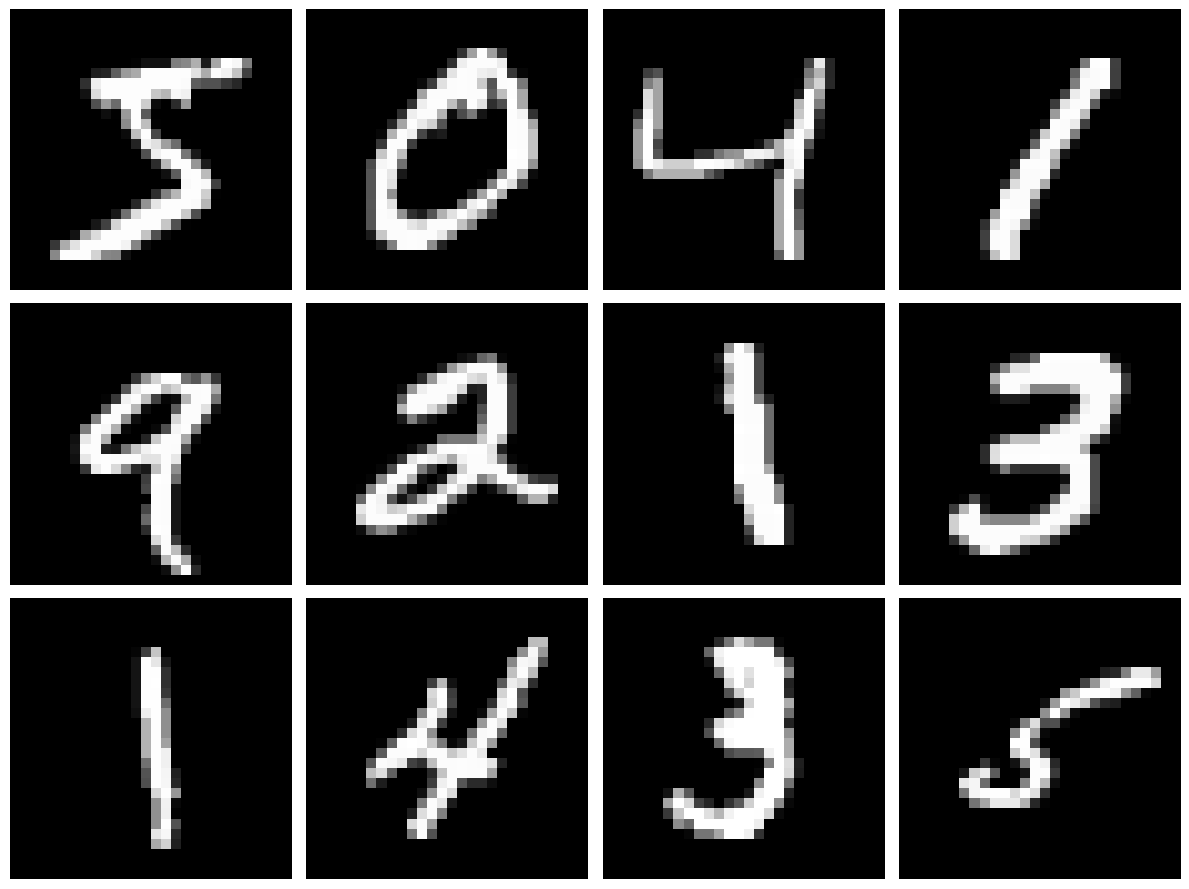

In [ ]:
display_mnist(x_img[:12])

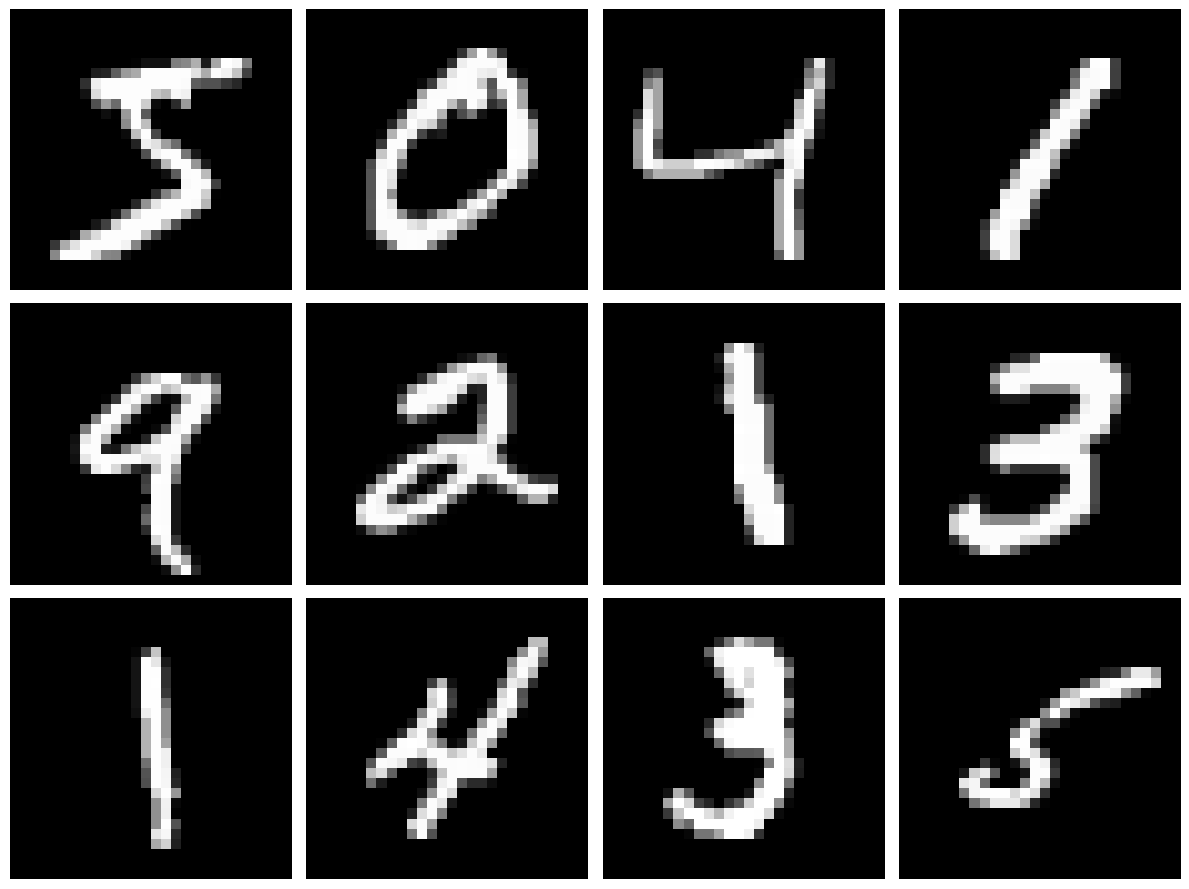

In [ ]:
x_gen = pca.generate(x_red[:12])
x_gen = x_gen.reshape(x_gen.shape[0], 28, 28)
display_mnist(x_gen)

# AutoEncoder

## Reduction

2023-06-07 01:40:11.657403: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2023-06-07 01:40:12.835991: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0487 - val_loss: 0.0389
Epoch 2/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0372 - val_loss: 0.0360
Epoch 3/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0352 - val_loss: 0.0345
Epoch 4/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0339 - val_loss: 0.0338
Epoch 5/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0331 - val_loss: 0.0330
Epoch 6/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0325 - val_loss: 0.0326
Epoch 7/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0320 - val_loss: 0.0322
Epoch 8/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0315 - val_loss: 0.0318
Epoch 9/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0312 - val_loss: 0.0317
Epoch 10/20
1875/1875 [==============================] - 20s 11m

TypeError: show() got an unexpected keyword argument 'interactive'

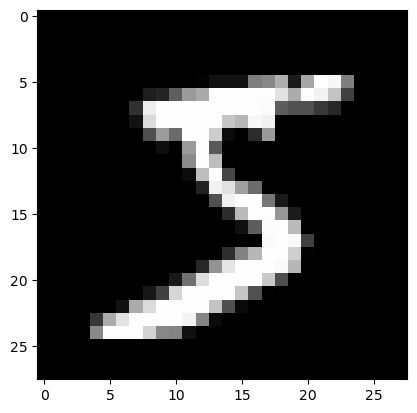

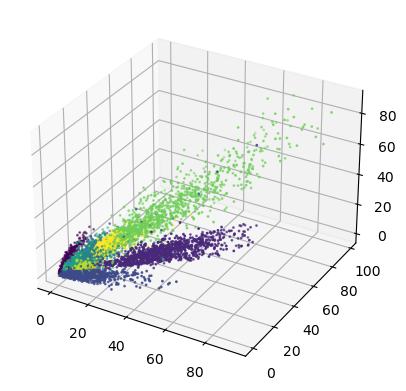

In [35]:
#Autoencoder

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset
x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1

plt.imshow(x_train[0], cmap="gray")

def autoencoder(input_shape):
  input = keras.Input(shape=input_shape)
  f = keras.layers.Flatten()(input)
  e = keras.layers.Dense(256,activation="relu")(f)
  e = keras.layers.Dense(128,activation="relu")(e)
  lat_space = keras.layers.Dense(3, activation="relu")(e)
  d = keras.layers.Dense(128, activation="relu")(lat_space)
  d = keras.layers.Dense(256, activation="relu")(d)
  regen = keras.layers.Dense(input_shape[0] * input_shape[1], activation="sigmoid")(d)
  reshaped = keras.layers.Reshape((28,28))(regen)

  autoencoder = keras.Model(input, reshaped)
  encoder = keras.Model(input, lat_space)
  decoder = keras.Model(lat_space, reshaped)
  opt = keras.optimizers.Adam()
  return autoencoder, encoder, decoder, opt

input_shape = (28,28)
autoencoder,encoder, decoder,opt = autoencoder(input_shape)

autoencoder.compile(opt, loss='mse')
autoencoder.fit(x_train,  x_train, epochs=20,  validation_data=[x_test, x_test])

encoded = np.array(encoder(x_test))

x = encoded[:,0]
y = encoded[:,1]
z = encoded[:,2]

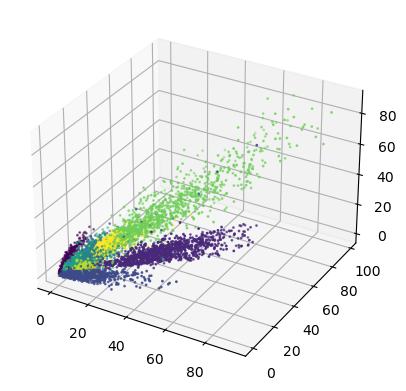

In [36]:
# Couleurs correspondant à chaque catégorie
unique_values = np.unique(y)
count = len(unique_values)
colors = list(mcolors.TABLEAU_COLORS.values())[:count]

# Création du scatter plot en 3D avec des couleurs différentes pour chaque catégorie
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=y_test, cmap=plt.cm.get_cmap('viridis', len(colors)), s=1)

# Affichage du plot
plt.show(block=True)

## Compression - Decompression

In [38]:
import tensorflow as tf  
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()  # loads the popular "mnist" training dataset
x_train = x_train/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1
x_test = x_test/255.0  # scales the data. pixel values range from 0 to 255, so this makes it range 0 to 1

11490434/11490434 [==============================] - 0s 0us/step


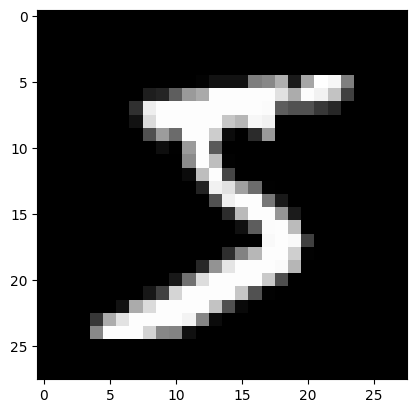

In [ ]:
plt.imshow(x_train[0], cmap="gray")

In [ ]:
def autoencoder_create():
  #encoderpart
  encoder_input = keras.Input(shape=(28, 28, 1), name='img')
  x = keras.layers.Flatten()(encoder_input)
  encoder_output = keras.layers.Dense(64, activation="relu")(x)
  encoder = keras.Model(encoder_input, encoder_output, name='encoder')
  #decoderpart
  decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
  x = keras.layers.Dense(784, activation="sigmoid")(decoder_input)
  decoder_output = keras.layers.Reshape((28, 28, 1))(x)
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000000000,
    decay_rate=1e-6)
  opt = tf.keras.optimizers.Adam(lr_schedule)
  return keras.Model(encoder_input, decoder_output, name='autoencoder'), opt, encoder

In [ ]:
autoencoder,opt, encoder = autoencoder_create()

In [ ]:
autoencoder.summary()

epochs = 5

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                50240     
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 784)               50960     
                                                                 
 reshape_5 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 105,360
Trainable params: 105,360
Non-tra

In [ ]:

autoencoder.compile(opt, loss='mse')
for epoch in range(epochs):

  history = autoencoder.fit(
    x_train,
    x_train,
    epochs=1, 
    batch_size=32, validation_split=0.10
      )   
  autoencoder.save(f"models/AE-{epoch+1}.model")

1688/1688 [==============================] - 10s 5ms/step - loss: 0.0186 - val_loss: 0.0124


1688/1688 [==============================] - 9s 5ms/step - loss: 0.0116 - val_loss: 0.0116


1688/1688 [==============================] - 8s 5ms/step - loss: 0.0112 - val_loss: 0.0110


1688/1688 [==============================] - 8s 5ms/step - loss: 0.0108 - val_loss: 0.0111


1688/1688 [==============================] - 8s 5ms/step - loss: 0.0108 - val_loss: 0.0103


In [ ]:
example = encoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])

1/1 [==============================] - 0s 54ms/step


In [ ]:
print(example[0].shape)
print(example[0])

(64,)
[0.6751566  0.         0.7857231  1.7377427  2.774129   4.9856753
 0.58372176 2.2027655  1.0402203  1.6963514  0.         1.7423773
 0.         0.         0.         4.2756433  0.         0.
 0.         0.         4.137318   0.8460165  0.11572971 0.
 1.2979872  3.7455034  3.733972   8.05626    4.9042373  1.6317742
 0.9605174  0.         0.930856   1.2050109  0.         7.2523375
 1.4798733  0.         0.         0.         0.         1.5572263
 0.         0.5862725  0.         2.3873758  1.5806131  1.6609681
 1.6169885  2.7324772  0.9008496  0.         0.         3.1551776
 0.         0.         0.         3.7590382  0.6161568  0.
 0.         0.         0.         5.85188   ]


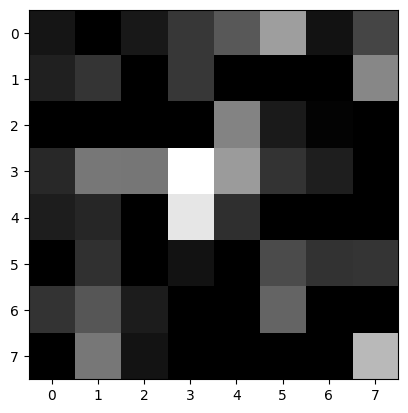

In [ ]:
plt.imshow(example[0].reshape((8,8)), cmap="gray")

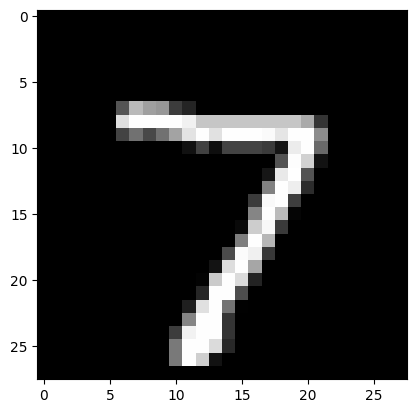

In [ ]:
plt.imshow(x_test[0], cmap="gray")

1/1 [==============================] - 0s 85ms/step


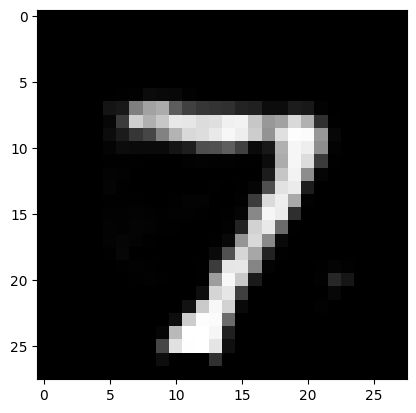

In [ ]:
ae_out = autoencoder.predict([ x_test[0].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

## Generate

In [39]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers
tf.keras.datasets.mnist.load_data(path="mnist.npz")

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [40]:
class Autoencoder:
  def __init__(self, x_train_, x_test_, opt = keras.optimizers.Adam()):
    self.x_train = x_train_/255.0
    self.x_test = x_test_/255.0
    self.shape = self.x_train[0].shape

    input = keras.Input(shape=(28, 28, 1))
    f = keras.layers.Flatten()(input)
    e = keras.layers.Dense(256,activation="relu")(f)
    e = keras.layers.Dense(128,activation="relu")(e)
    lat_space = keras.layers.Dense(8, activation="relu")(e)
    d = keras.layers.Dense(128, activation="relu")(lat_space)
    d = keras.layers.Dense(256, activation="relu")(d)
    regen = keras.layers.Dense(self.shape[0] * self.shape[1], activation="sigmoid")(d)
    reshaped = keras.layers.Reshape((28,28))(regen)

    self.__autoencoder = keras.Model(input, reshaped)
    self._encoder = keras.Model(input, lat_space)
    self._decoder = keras.Model(lat_space, reshaped)
    self.opt = opt

  def fit(self, loss = "mse", epochs: int = 20, batchsize: int = 32):
    self.__autoencoder.compile(self.opt, loss=loss)
    self.__autoencoder.fit(self.x_train, self.x_train, epochs = epochs, batch_size=batchsize, validation_data=[self.x_test, self.x_test])

  def encode(self, data):
    return self._encoder.predict(data)
  
  def decode(self, data):
    return self._decoder.predict(data)

In [41]:
AEncoder = Autoencoder(x_train, x_test)
AEncoder.fit(epochs=20)

2023-06-07 01:58:34.059466: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0323 - val_loss: 0.0231
Epoch 2/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0220 - val_loss: 0.0206
Epoch 3/20
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0199 - val_loss: 0.0194
Epoch 4/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0188 - val_loss: 0.0184
Epoch 5/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0181 - val_loss: 0.0180
Epoch 6/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0176 - val_loss: 0.0176
Epoch 7/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 8/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 9/20
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 10/20
1875/1875 [==============================] - 17s 9ms/step

In [42]:
encoded = AEncoder.encode([x_train])
t_enc = encoded.T
t_enc.shape

(8, 60000)

In [47]:
from random import uniform

minmax_ae = []

for i in range(8):
  minmax_ae.append((t_enc[i].min(), t_enc[i].max()))

to_decode = []

for _ in range(16):
  tmp = []
  for i in range(8):
    tmp.append(uniform(minmax_ae[i][0], minmax_ae[i][1]))
  to_decode.append(tmp)

to_decode = np.array(to_decode)

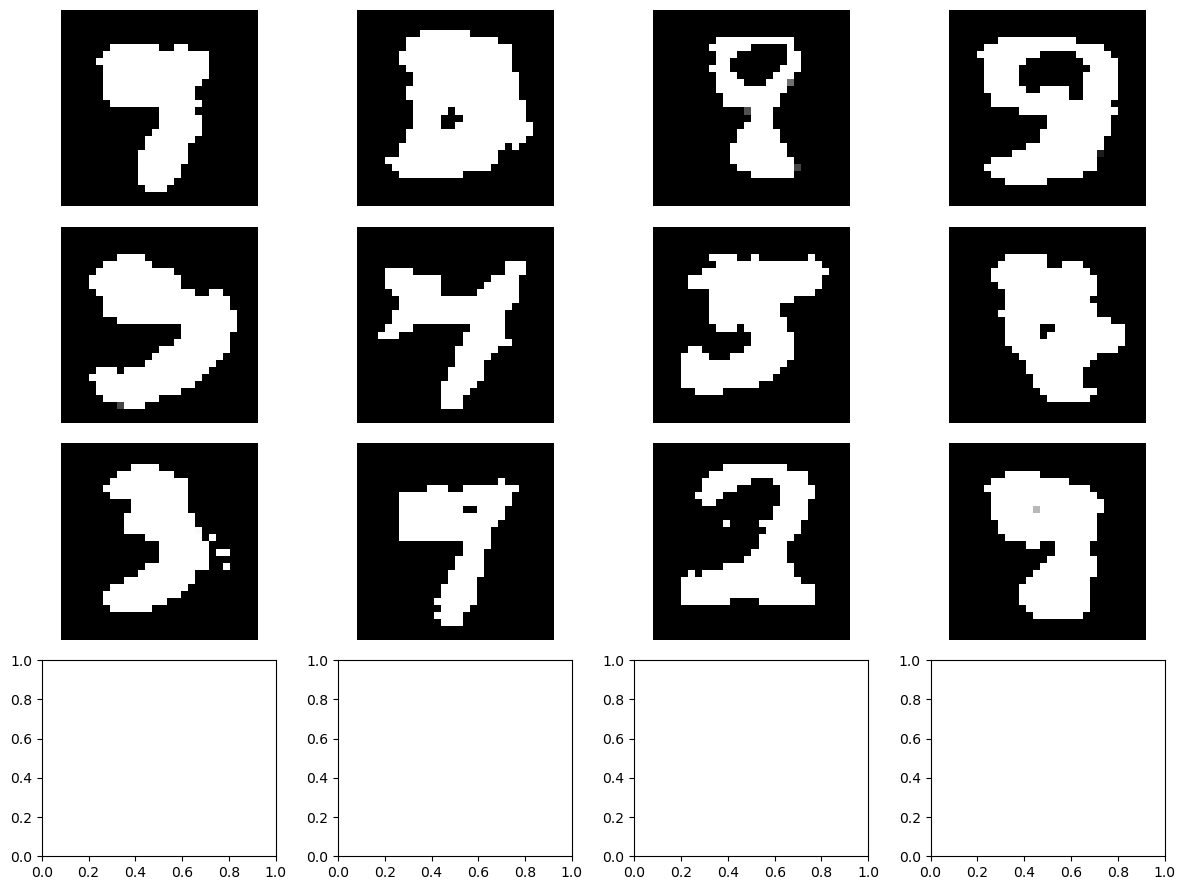

In [48]:
decoded = AEncoder.decode(to_decode)

d_shape = decoded.reshape(decoded.shape[0], 28, 28)

display_mnist(d_shape)